<a href="https://colab.research.google.com/github/evan-placenis/Generative-Variational-Auto-Encoder/blob/main/Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
from tensorflow.keras import datasets

(x_train, y_train) , (x_test, y_test) = datasets.fashion_mnist.load_data()

In [80]:
import numpy as np
def preprocess(imgs):
  imgs = imgs.astype("float32")/ 255.0
  imgs = np.pad(imgs,((0,0), (2,2), (2,2)), constant_values = 0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

## AutoEncoder - MNIST

**Encoder**

In [3]:
from tensorflow.keras import layers, models, backend as K

encoder_input = layers.Input(shape = (32,32, 1), name = "encoder input")
#halve the size of input tensor by setting strides to 2
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
#2 for 2-dimensional latent space
encoder_output = layers.Dense(2, name = "encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)


***Decoder***

In [4]:
from tensorflow.keras import layers, models

decoder_input = layers.Input(shape = (2,), name = "decoder input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
#double the size of input tensor by setting strides to 2
x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)

#2 for 2-dimensional latent space
decoder_output = layers.Conv2D(1, (3,3), strides = 1, activation = "sigmoid", padding = "same", name = "decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)


**AutoEncoder**

In [5]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

import tensorflow as tf

autoencoder.compile(optimizer = "adam",
                    loss = "binary_crossentropy")

autoencoder.fit(x_train,
                x_train,
                epochs = 5,
                batch_size = 100,
                shuffle = True,
                validation_data = (x_test, x_test))

Epoch 1/5
600/600 [==============================] - 25s 14ms/step - loss: 0.2922 - val_loss: 0.2614
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2570 - val_loss: 0.2568
Epoch 3/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2539 - val_loss: 0.2545
Epoch 4/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2519 - val_loss: 0.2524
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2504 - val_loss: 0.2513


Top row = Real Images, Bottom Row = autoencoder images

1/1 [==============================] - 0s 178ms/step


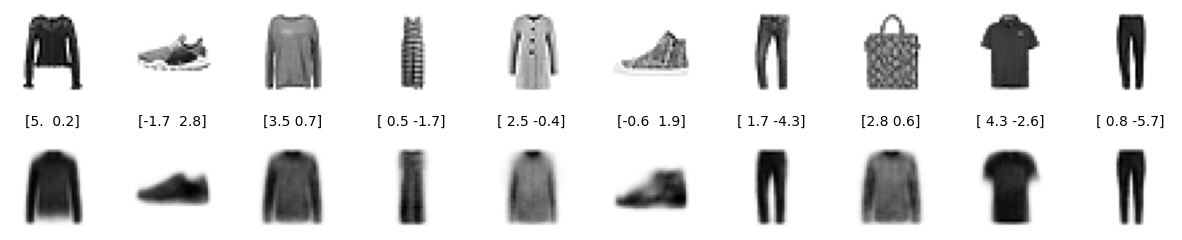

In [6]:
import matplotlib.pyplot as plt
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = encoder.predict(example_images)

predictions = autoencoder.predict(example_images)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = predictions[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

**Plot the latent space to see how it is undesirable**

157/157 [==============================] - 0s 2ms/step


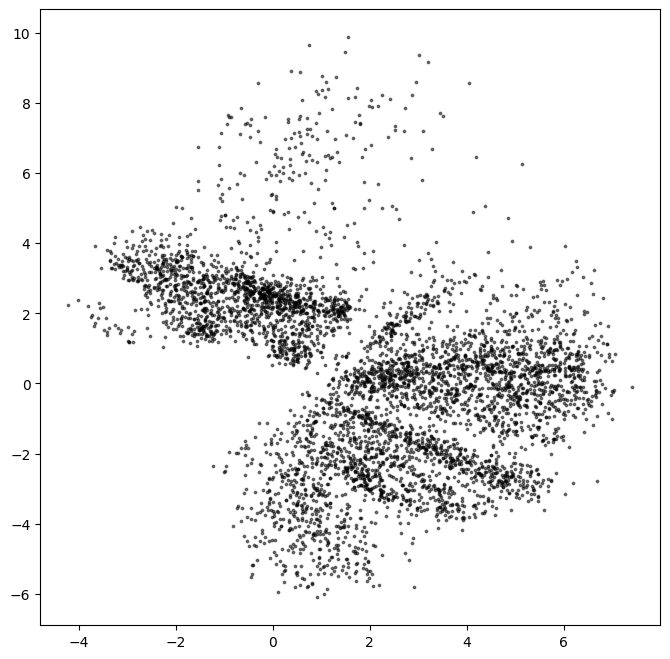

In [7]:
example_images = x_test[:5000]
embeddings = encoder.predict(example_images)

plt.figure(figsize = (8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c = "black", alpha = 0.5, s = 3)
plt.show()
#this latent space does not have a gaussian distribution

## 2D Variational Autoencoders - MNIST

In [86]:
#sampling layer that will allow us to sample from the distribution from (z_mean and z_log_var)'

class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) *epsilon

**New Encoder**

In [87]:
encoder_input = layers.Input(shape = (32, 32, 1), name = "encoder_input")
#halve the size of input tensor by setting strides to 2
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
#2 for 2-dimensional latent space
z_mean = layers.Dense(2, name = "z_mean")(x)
z_log_var = layers.Dense(2, name = "z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z])

**Same Decoder**

In [88]:
from tensorflow.keras import layers, models

decoder_input = layers.Input(shape = (2,), name = "decoder input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
#double the size of input tensor by setting strides to 2
x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)

#2 for 2-dimensional latent space
decoder_output = layers.Conv2D(1, (3,3), strides = 1, activation = "sigmoid", padding = "same", name = "decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)


**Introducing the KL Divergence loss [center embeddings in latent space closer to (0,0)] in addition to the Reconstruction Loss**

In [89]:
from tensorflow.keras import metrics, losses

class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name = "total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(name = "reconstruction_loss")
    self.kl_loss_tracker = metrics.Mean(name = "kl_loss")

  @property
  def metrics(self):
    return[self.total_loss_tracker,
           self.reconstruction_loss_tracker,
           self.kl_loss_tracker]

  def call(self, inputs):
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)

      reconstruction_loss = tf.reduce_mean(
          500 * losses.binary_crossentropy(data,reconstruction, axis=(1,2,3))
      )

      kl_loss = tf.reduce_mean(
          tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1)
      )

      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return{m.name : m.result() for m in self.metrics}

In [90]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = "adam")
vae.fit(x_train,
        epochs = 5,
        batch_size = 100
        )

Epoch 1/5
600/600 [==============================] - 12s 14ms/step - total_loss: 153.6842 - reconstruction_loss: 149.3367 - kl_loss: 4.3474
Epoch 2/5
600/600 [==============================] - 6s 9ms/step - total_loss: 134.2540 - reconstruction_loss: 129.2707 - kl_loss: 4.9833
Epoch 3/5
600/600 [==============================] - 6s 10ms/step - total_loss: 132.8057 - reconstruction_loss: 127.7006 - kl_loss: 5.1053
Epoch 4/5
600/600 [==============================] - 6s 9ms/step - total_loss: 132.0811 - reconstruction_loss: 126.8958 - kl_loss: 5.1854
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - total_loss: 131.5998 - reconstruction_loss: 126.3688 - kl_loss: 5.2311


**New Latent Space**

157/157 [==============================] - 0s 2ms/step


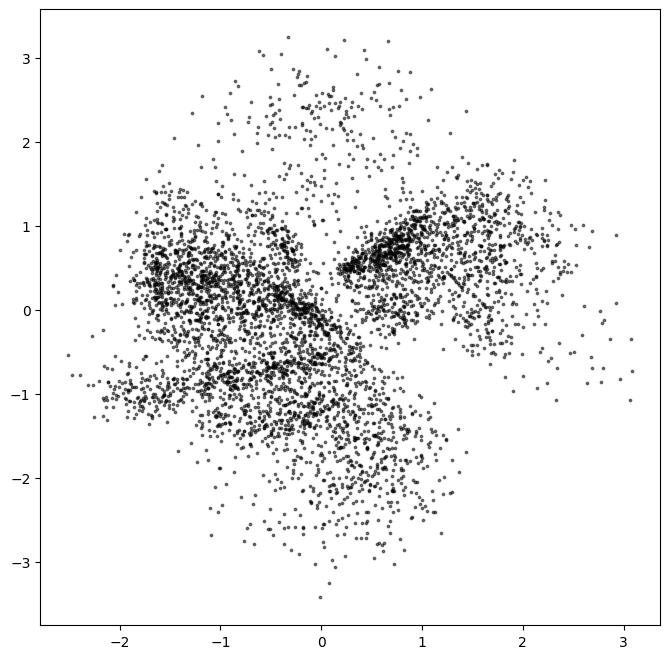

In [92]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 200D Variational Autoencoder - CelebA

#### Downloading Kaggle CelebA Dataset

In [13]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/KaggleAPI/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [14]:
! kaggle datasets download jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:07<00:00, 25.1MB/s]
100% 1.33G/1.33G [01:07<00:00, 21.2MB/s]


In [15]:
!unzip /content/celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

#### Training Variational AutoEncoder

In [45]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/img_align_celeba/img_align_celeba",
    labels = None,
    color_mode = "rgb",
    image_size = (64,64),
    batch_size = 128,
    shuffle = True,
    seed = 42,
    interpolation = "bilinear")

Found 202599 files belonging to 1 classes.


In [46]:
def preprocess(img):
  img = tf.cast(img, "float32")/ 255.0
  return img
train = train_data.map(lambda x: preprocess(x))

***Create new Encoder / Decoder and use it in the existing VAE but change one hyperparameter***

In [47]:
#sampling layer that will allow us to sample from the distribution from (z_mean and z_log_var)'

class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) *epsilon

In [48]:
encoder_input = layers.Input(shape = (64, 64, 3), name = "encoder_input")
#halve the size of input tensor by setting strides to 2
x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding = "same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)

#200 for 200-dimensional latent space
z_mean = layers.Dense(200, name = "z_mean")(x)
z_log_var = layers.Dense(200, name = "z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z])

In [49]:
from tensorflow.keras import layers, models

decoder_input = layers.Input(shape = (200,), name = "decoder input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)

#double the size of input tensor by setting strides to 2
x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

#2 for 2-dimensional latent space
decoder_output = layers.Conv2DTranspose(3, (3,3), strides = 1, activation = "sigmoid", padding = "same", name = "decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)


In [50]:
from tensorflow.keras import metrics, losses

class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name = "total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(name = "reconstruction_loss")
    self.kl_loss_tracker = metrics.Mean(name = "kl_loss")

  @property
  def metrics(self):
    return[self.total_loss_tracker,
           self.reconstruction_loss_tracker,
           self.kl_loss_tracker]

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstruction = self.decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)

      reconstruction_loss = tf.reduce_mean(
          2000 * losses.binary_crossentropy(data,reconstruction, axis=(1,2,3))
      )

      kl_loss = tf.reduce_mean(
          tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1)
      )

      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return{m.name : m.result() for m in self.metrics}

In [51]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = "adam")
vae.fit(train,
        epochs = 3,
        batch_size = 100
        )

Epoch 1/3
1583/1583 [==============================] - 259s 157ms/step - total_loss: 1107.4163 - reconstruction_loss: 1078.3451 - kl_loss: 29.0706
Epoch 2/3
1583/1583 [==============================] - 248s 156ms/step - total_loss: 1075.2672 - reconstruction_loss: 1041.6748 - kl_loss: 33.5905
Epoch 3/3
1583/1583 [==============================] - 247s 156ms/step - total_loss: 1071.2621 - reconstruction_loss: 1036.6993 - kl_loss: 34.5634


**Generating new Facing with our model**

1/1 [==============================] - 0s 433ms/step


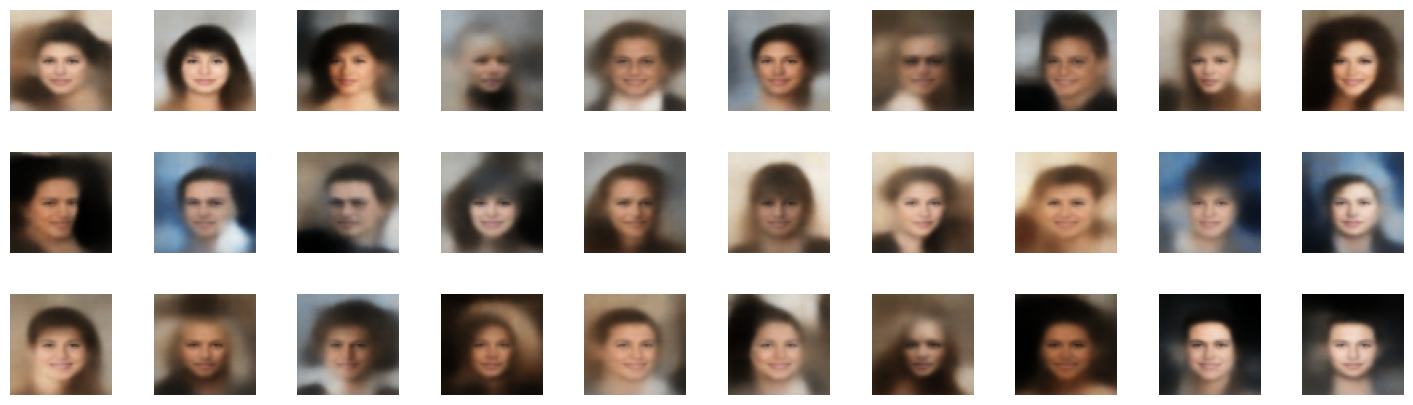

In [52]:
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size = (grid_width * grid_height, 200))
reconstructions = decoder.predict(z_sample)

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace = 0.4)
for i in range(grid_width*grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i + 1)
  ax.axis("off")
  ax.imshow(reconstructions[i, :, :])


**View Latent Space Distribution**

4/4 [==============================] - 0s 4ms/step


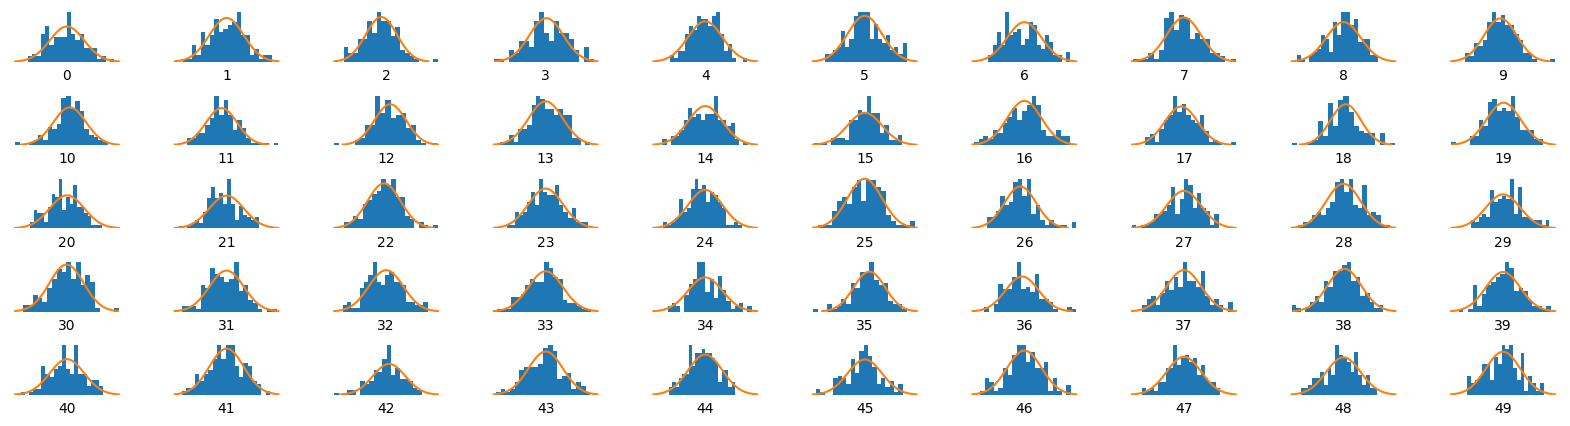

In [56]:
#if distributions stand out as being significantlt different from standard normal we should reduce beta factor
from scipy.stats import norm
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

##**Manipulate the Images**

In [60]:
# Load the label dataset
import pandas as pd
attributes = pd.read_csv("/content/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [70]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200

In [61]:
# Load the face data with label attached
LABEL = "Blond_Hair"
labelled_test = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/img_align_celeba/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(64, 64),
    batch_size=128,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


####Functions

In [62]:
def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector

In [63]:

def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


In [64]:
def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

In [67]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 2.858    : 1.592    : 3.32    : 3.32
44    : 1.954    : 0.914    : 2.681    : -0.639
65    : 1.128    : 0.57    : 2.287    : -0.394
87    : 0.77    : 0.41    : 2.105    : -0.182
110    : 0.653    : 0.315    : 1.962    : -0.143
128    : 0.467    : 0.251    : 1.909    : -0.053
150    : 0.452    : 0.192    : 1.864    : -0.045
171    : 0.36    : 0.177    : 1.859    : -0.005
197    : 0.408    : 0.155    : 1.819    : -0.04
218    : 0.287    : 0.151    : 1.775    : -0.044
241    : 0.298    : 0.138    : 1.763    : -0.011
260    : 0.242    : 0.121    : 1.758    : -0.006
282    : 0.23    : 0.105    : 1.748    : -0.009
302    : 0.228    : 0.097    : 1.713    : -0.035
317    : 0.176    : 0.098    : 1.702    : -0.012
337    : 0.176    : 0.085    : 1.689    : -0.013
356    : 0.167    : 0.086    : 1.671    : -0.018
377    : 0.179    : 0.078    : 1.651    : -0.02
395    : 0.156    : 0.077    : 1.644    : -0.007
415    : 0.14

#### Output

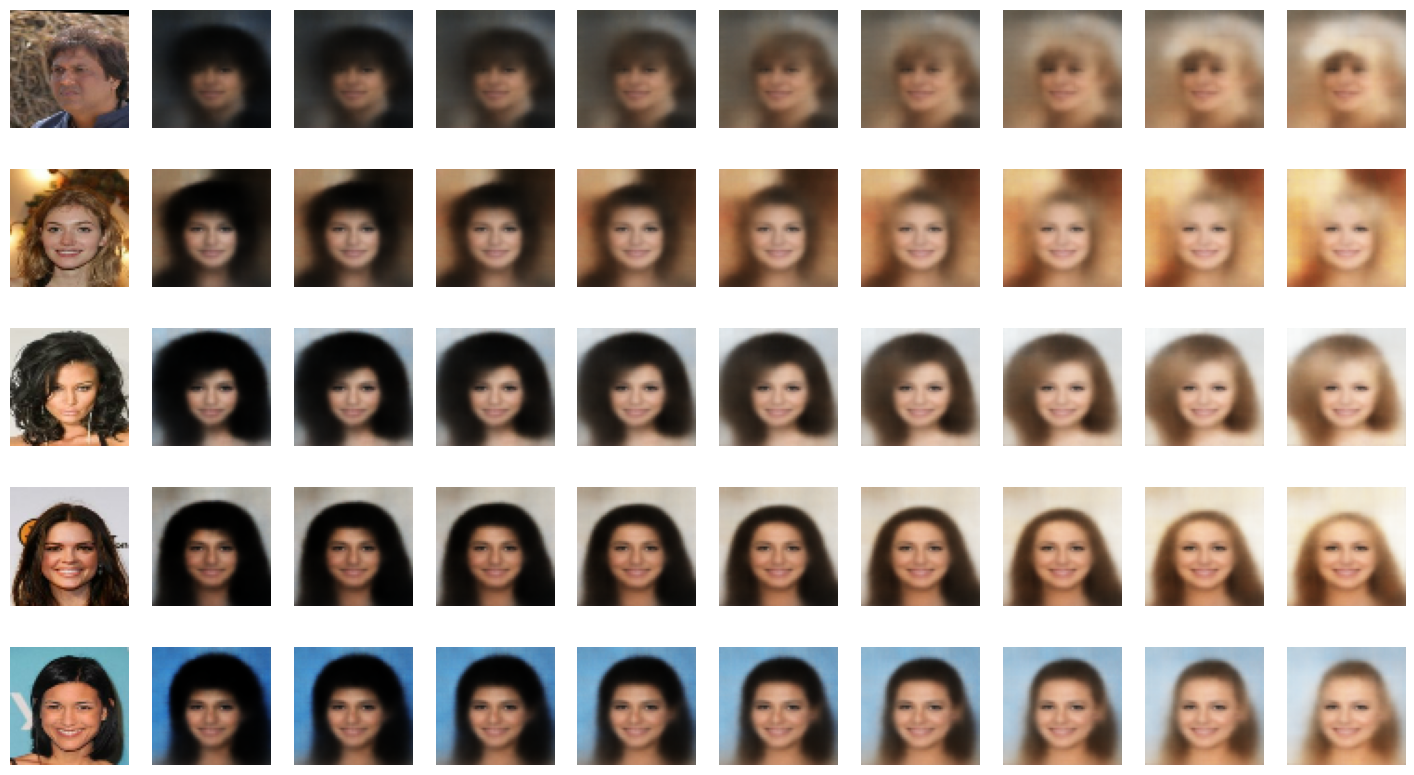

In [68]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

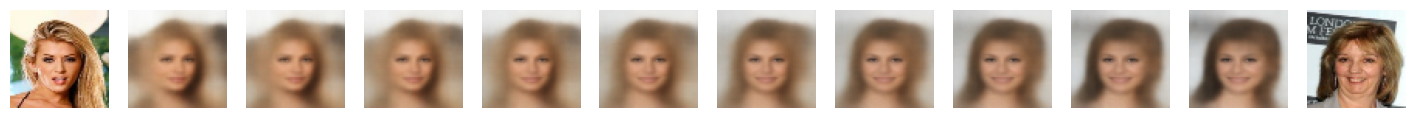

In [69]:
morph_faces(labelled, vae)